In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
from himalaya.backend import set_backend
from matplotlib import pyplot as plt
import simplstyles
from voxelwise_tutorials.io import load_hdf5_array

from fmri.features import load_brain_data
from fmri.features import load_feature
from fmri.plotting import plot_flatmap_from_mapper
from fmri.ridge import run_ridge_pipeline, run_banded_pipeline

In [2]:
def get_result_path(modality, subject):
    path = os.path.join("results", modality, f"subject{subject:02}")
    os.makedirs(path, exist_ok=True)
    return path

In [3]:
plt.style.use('nord-light-talk')
data_dir = "../../data"
backend = set_backend('torch_cuda', on_error='warn')
simplstyles.styles

{'clean-light-talk': RcParams({'axes.axisbelow': True,
           'axes.edgecolor': '#b7bdc8',
           'axes.facecolor': 'white',
           'axes.grid': False,
           'axes.labelcolor': '#454c54',
           'axes.labelsize': 18.0,
           'axes.linewidth': 1.25,
           'axes.prop_cycle': cycler('color', ['#418ace', '#e37064', '#47b8b3', '#8a56bd', '#d4596d', '#e5ac62', '#9da2ae']),
           'axes.spines.right': False,
           'axes.spines.top': False,
           'axes.titlelocation': 'left',
           'axes.titlesize': 18.0,
           'axes.titleweight': 'bold',
           'boxplot.showbox': False,
           'boxplot.showcaps': False,
           'boxplot.showfliers': False,
           'figure.facecolor': 'white',
           'font.family': ['sans-serif'],
           'font.sans-serif': ['Inter', 'Helvetica', 'Arial', 'sans-serif'],
           'font.size': 16.0,
           'grid.color': '#e4eaf6',
           'grid.linestyle': '-',
           'grid.linewidth': 1.25,

In [4]:
modality = "reading"
subject = 1
low_level_feature = "letters"
trim = 5  # remove 5 TRs from the start and end of each story
number_of_delays = 4

In [5]:
alphas = np.logspace(-5, 25, 20)
cv = 5
n_iter = 10

In [6]:
n_targets_batch = 100
n_alphas_batch = 5
n_targets_batch_refit = 100

## Load Low Level Feature

In [7]:
X_low_level, n_samples_train = load_feature(data_dir, low_level_feature)

## Load High Level (NLP) Features

In [8]:
X_semantic, n_samples_train = load_feature(data_dir, "english1000")

# Load Brain Data

In [9]:
Y, n_samples_train = load_brain_data(data_dir, subject, modality)

/home/leo/PycharmProjects/compare_variance_residual/compare_variance_residual/fmri/features.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Y_train = np.vstack([zscore(Y_train[story][:-trim]) for story in Y_train.keys()])
/home/leo/PycharmProjects/compare_variance_residual/compare_variance_residual/fmri/features.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Y_train = np.vstack([zscore(Y_train[story][:-trim]) for story in Y_train.keys()])
/home/leo/PycharmProjects/compare_variance_residual/compare_variance_residual/fmri/features.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Y_train = np.vstack(

# Variance Partitioning

## Low Level Prediction

In [10]:
low_level_file = os.path.join(get_result_path(modality, subject), f"{low_level_feature}_scores.csv")

In [11]:
if not os.path.exists(low_level_file):
    print(f"Saving {low_level_file}")
    vp_low_level_scores = run_ridge_pipeline(X_low_level, Y, n_samples_train, alphas, cv,
                                             number_of_delays, n_targets_batch, n_alphas_batch, n_targets_batch_refit)
    vp_low_level_scores.to_csv(low_level_file)
else:
    print(f"Loading {low_level_file}")
    vp_low_level_scores = pd.read_csv(low_level_file, index_col=0)

# remove nan values
print(vp_low_level_scores.max(), vp_low_level_scores.min(), vp_low_level_scores.mean())

Saving results/reading/subject01/letters_scores.csv


/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


correlation_score    0.513446
r2_score             0.263613
p_value              0.999975
dtype: float64 correlation_score   -2.179484e-01
r2_score            -2.310504e+14
p_value              1.826357e-42
dtype: float64 correlation_score    4.094532e-02
r2_score            -2.041981e+10
p_value              3.430475e-01
dtype: float64


In [12]:
mapper_path = os.path.join("../../data", 'mappers', f"subject{subject:02}_mappers.hdf")
flatmap_mask = load_hdf5_array(mapper_path, key='flatmap_mask')

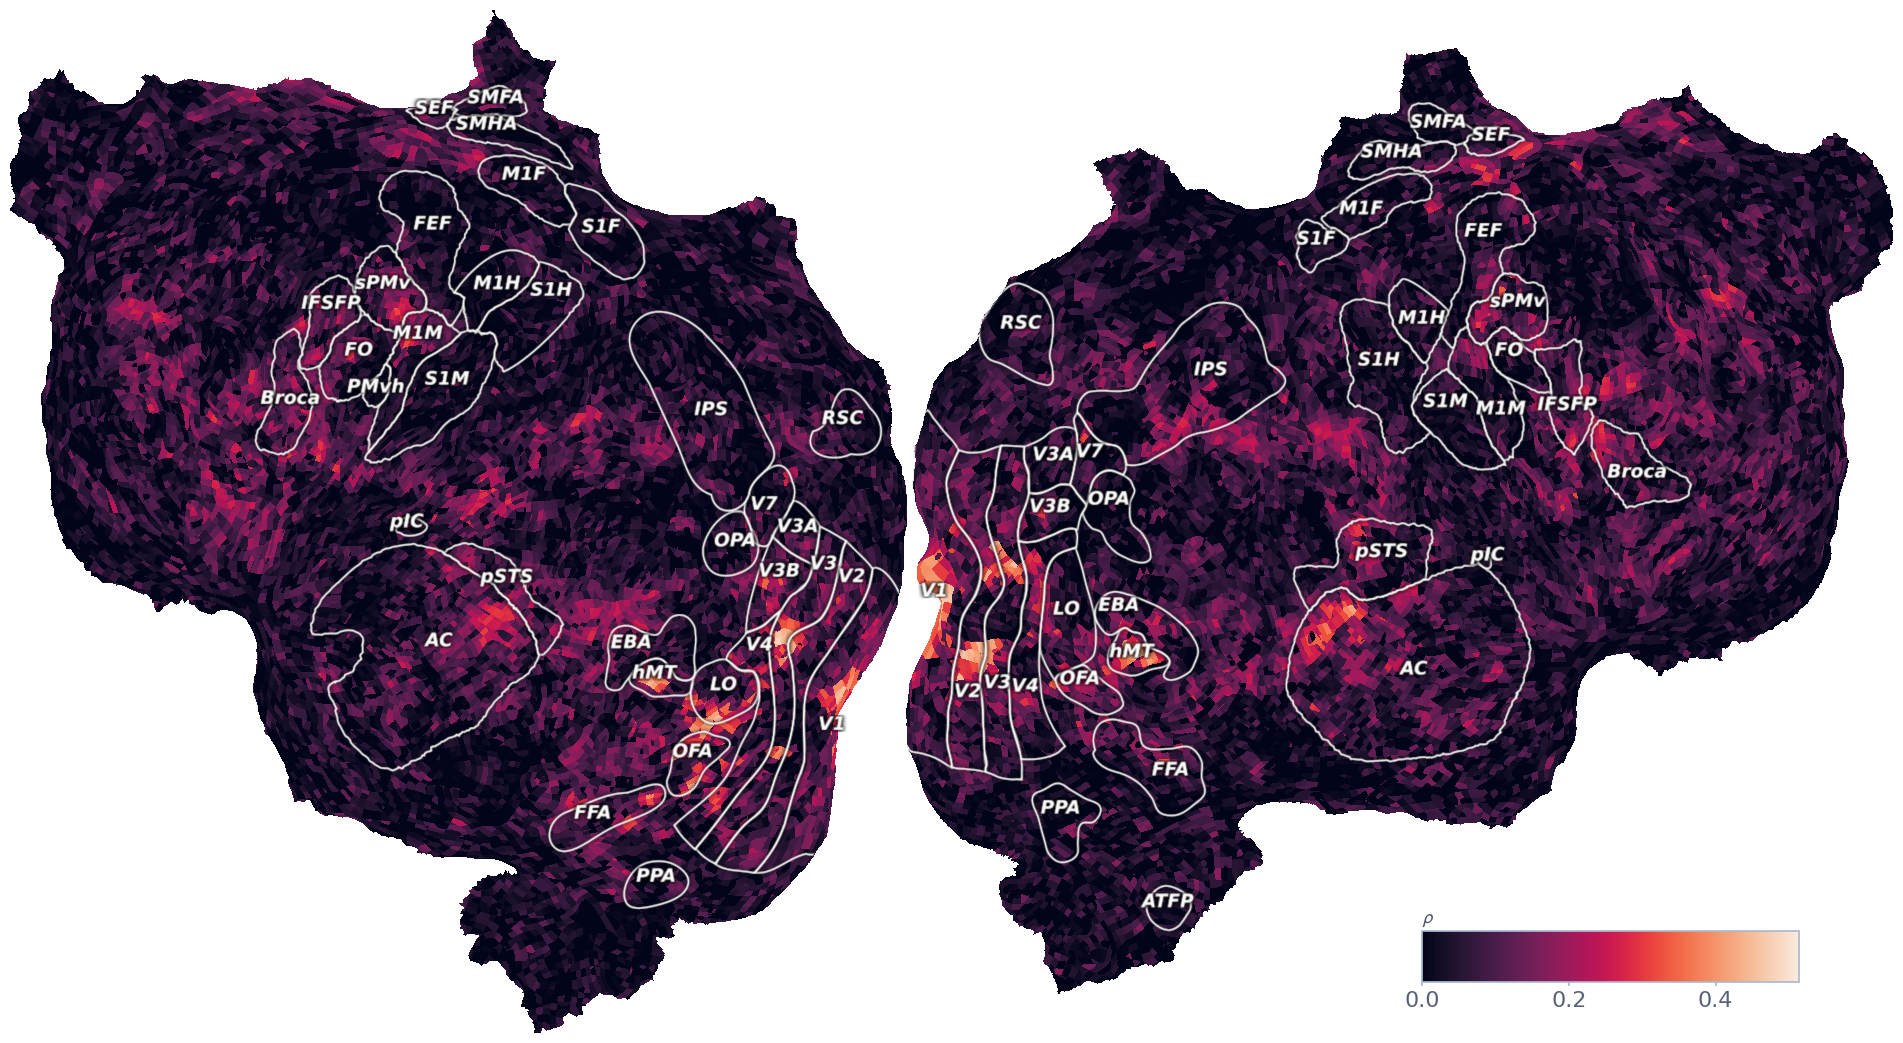

In [13]:
figsize = np.array(flatmap_mask.shape) / 100.
fig = plt.figure(figsize=figsize)
ax = fig.add_axes((0, 0, 1, 1))
ax.axis('off')

vp_low_level_correlation = vp_low_level_scores['correlation_score']
vp_low_level_correlation = vp_low_level_correlation.to_numpy()
vp_low_level_correlation = np.nan_to_num(vp_low_level_correlation)

plot_flatmap_from_mapper(vp_low_level_correlation, mapper_path, ax=ax, with_curvature=False, alpha=1, vmin=0,
                         # vmin=np.min(correlation),
                         vmax=np.max(vp_low_level_correlation),
                         colorbar_location=[0.75, 0.05, 0.2, 0.05])

plt.show()

## Semantic Prediction

In [14]:
semantic_file = os.path.join(get_result_path(modality, subject), f"english1000_scores.csv")

In [ ]:
if not os.path.exists(semantic_file):
    print(f"Saving {semantic_file}")
    vp_semantic_scores = run_ridge_pipeline(X_semantic, Y, n_samples_train, alphas, cv, number_of_delays,
                                            n_targets_batch, n_alphas_batch, n_targets_batch_refit)
    vp_semantic_scores.to_csv(semantic_file)
else:
    print(f"Loading {semantic_file}")
    vp_semantic_scores = pd.read_csv(semantic_file, index_col=0)

# remove nan values
print("max\n", vp_semantic_scores.max(), "\nmin\n", vp_semantic_scores.min(), "\nmean\n", vp_semantic_scores.mean())

Saving results/reading/subject01/english1000_scores.csv


/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/himalaya/ridge/_random_search.py:491: UserWarning: Solving ridge is slower than solving kernel ridge when n_samples < n_features (here 3887 < 3940). Using a linear kernel in himalaya.kernel_ridge.KernelRidgeCV or himalaya.kernel_ridge.solve_kernel_ridge_cv_eigenvalues would be faster. Use warn=False to silence this warning.
  warnings.warn(


0.5396399040317759


<Axes: >

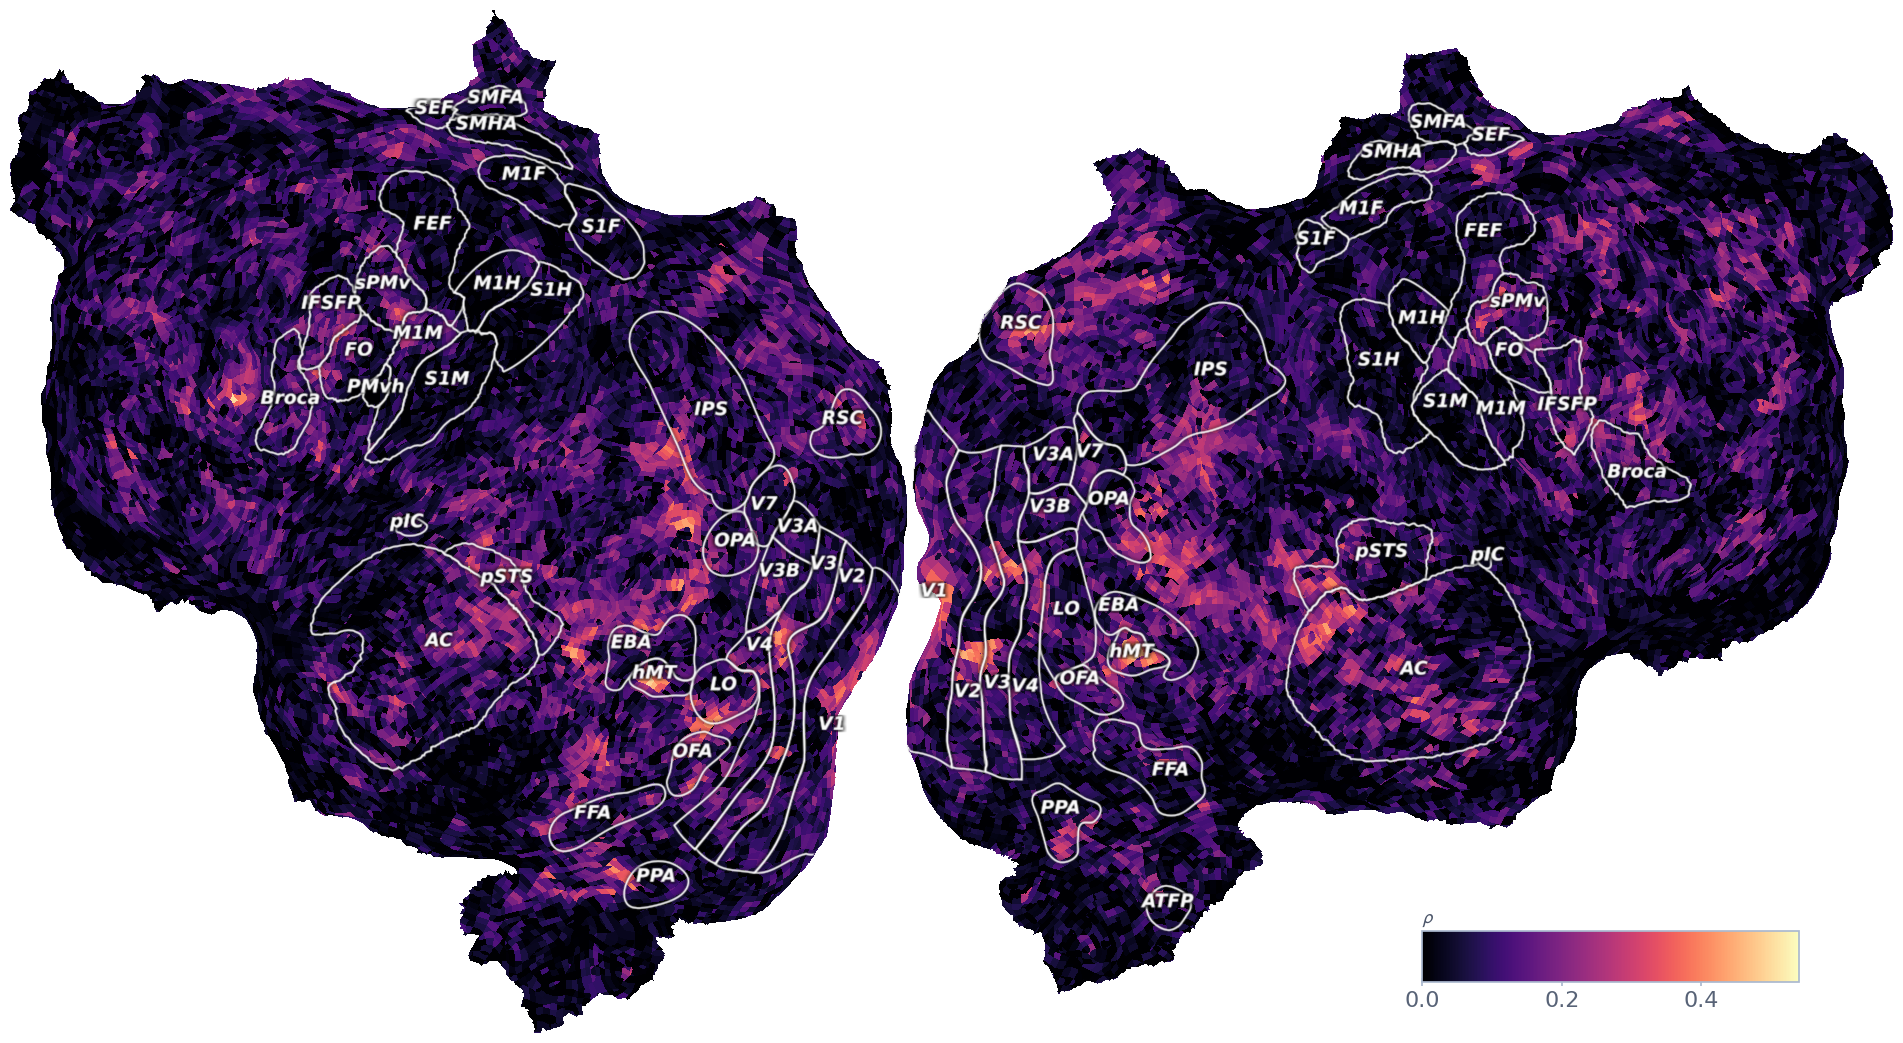

In [43]:
figsize = np.array(flatmap_mask.shape) / 100.
fig = plt.figure(figsize=figsize)
ax = fig.add_axes((0, 0, 1, 1))
ax.axis('off')

vp_semantic_correlation = vp_semantic_scores['correlation_score']
vp_semantic_correlation = vp_semantic_correlation.to_numpy()
vp_semantic_correlation = np.nan_to_num(vp_semantic_correlation)
vmax = vp_semantic_correlation.max()
print(vmax)

plot_flatmap_from_mapper(vp_semantic_correlation, mapper_path, ax=ax, with_curvature=False, alpha=1, vmin=0,
                         vmax=vmax, colorbar_location=[0.75, 0.05, 0.2, 0.05])


## Joint Prediction

In [44]:
joint_file = os.path.join(get_result_path(modality, subject), f"joint_english1000_{low_level_feature}_scores.csv")

In [49]:
if not os.path.exists(joint_file):
    print(f"Saving {joint_file}")
    vp_joint_scores = run_banded_pipeline(np.concatenate([X_semantic, X_low_level], axis=1),
                                          [X_semantic.shape[1], X_low_level.shape[1]], Y, n_samples_train, alphas,
                                          cv, n_iter, number_of_delays, n_targets_batch, n_alphas_batch,
                                          n_targets_batch_refit)
    vp_joint_scores.to_csv(joint_file)
else:
    print(f"Loading {joint_file}")
    vp_joint_scores = pd.read_csv(joint_file, index_col=0)

# remove nan values
print("max\n", vp_joint_scores.max(), "\nmin\n", vp_joint_scores.min(), "\nmean\n", vp_joint_scores.mean())

Saving results/reading/subject01/joint_english1000_letters_scores.csv


/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[                                        ] 0% | 0.00 sec | 10 random sampling with cv | 

/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/himalaya/ridge/_random_search.py:140: UserWarning: Solving banded ridge is slower than solving multiple-kernel ridge when n_samples < n_features (here 3887 < 4044). Using linear kernels in himalaya.kernel_ridge.MultipleKernelRidgeCV or himalaya.kernel_ridge.solve_multiple_kernel_ridge_random_search would be faster. Use warn=False to silence this warning.
  warnings.warn(


TypeError: 'module' object is not callable

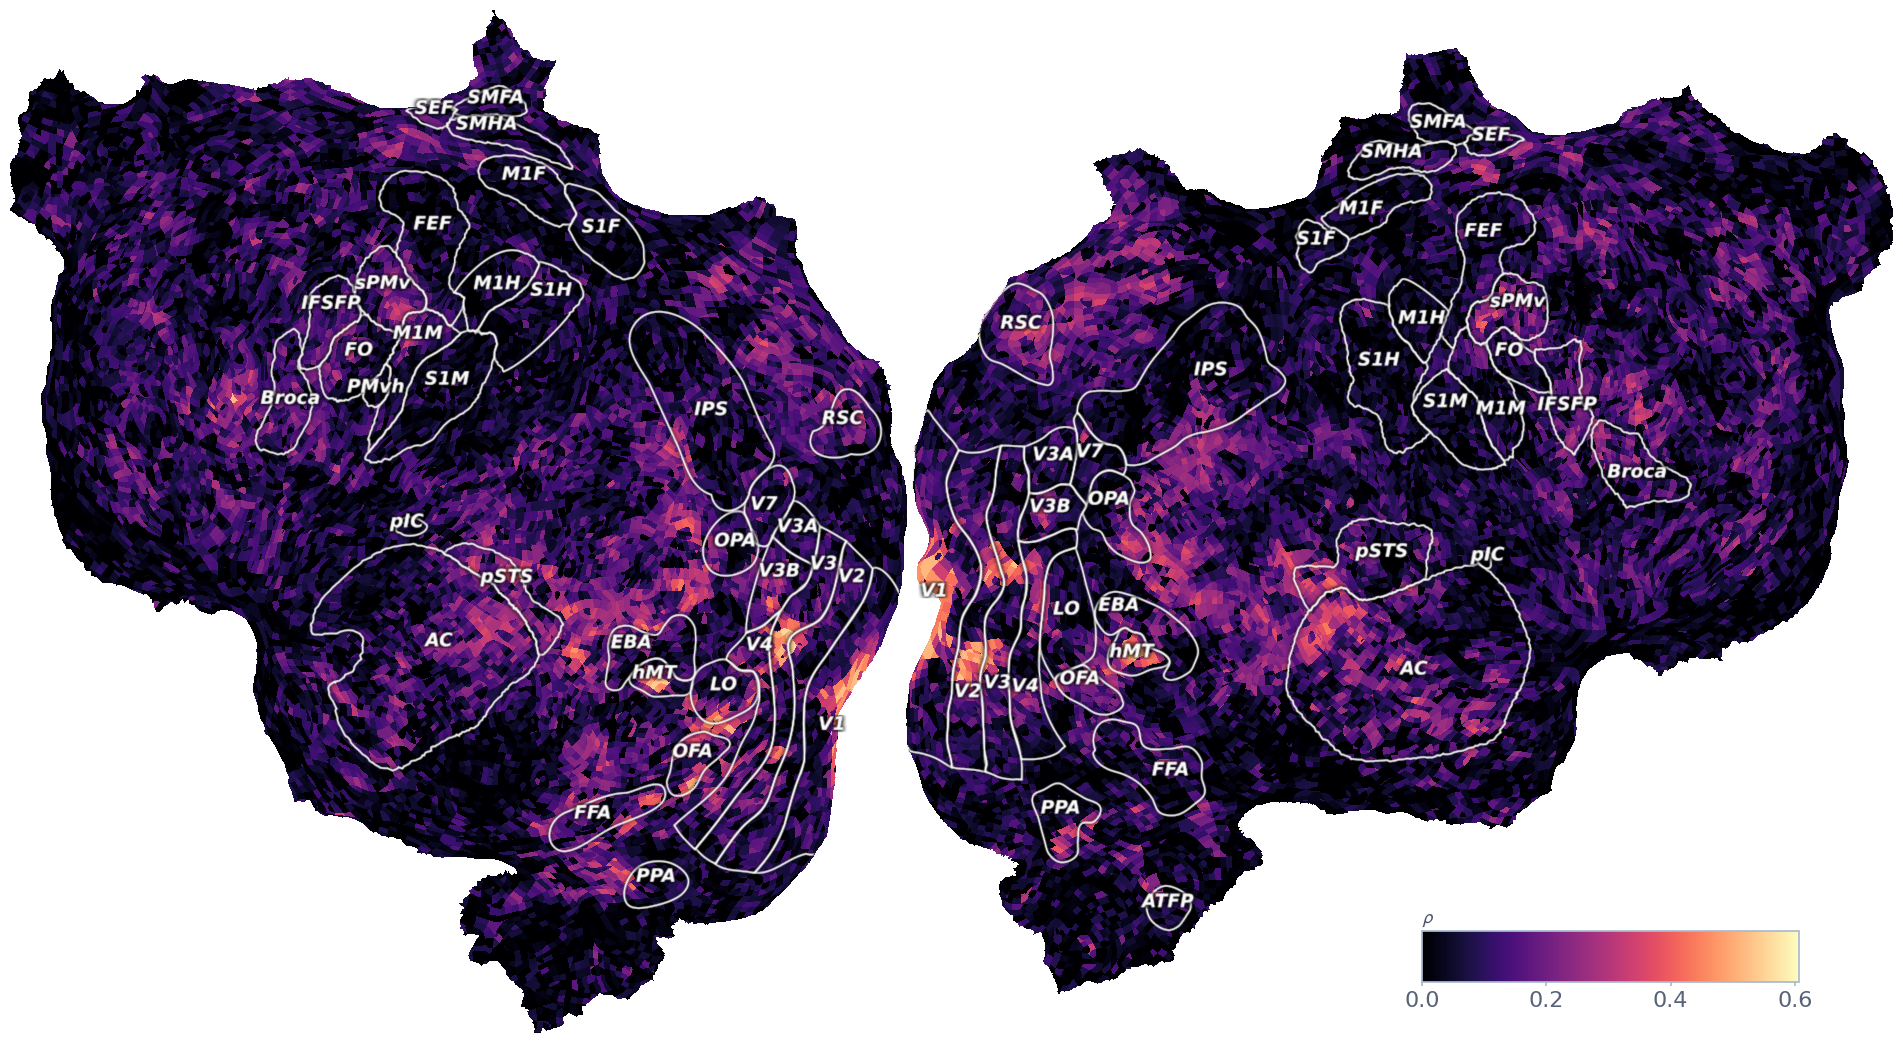

In [46]:
figsize = np.array(flatmap_mask.shape) / 100.
fig = plt.figure(figsize=figsize)
ax = fig.add_axes((0, 0, 1, 1))
ax.axis('off')

vp_joint_correlation = vp_joint_scores['correlation_score']
vp_joint_correlation = vp_joint_correlation.to_numpy()
vp_joint_correlation = np.nan_to_num(vp_joint_correlation)

plot_flatmap_from_mapper(vp_joint_correlation, mapper_path, ax=ax, with_curvature=False, alpha=1, vmin=0,
                         vmax=np.max(vp_joint_correlation), colorbar_location=[0.75, 0.05, 0.2, 0.05])

plt.show()

## Perform Variance Partitioning

In [48]:
def signed_square(r):
    return r ** 2 * np.sign(r)


intersection = signed_square(vp_joint_scores['correlation_score']) + signed_square(
    vp_low_level_scores['correlation_score']) - signed_square(vp_semantic_scores['correlation_score'])
semantic_minus_low_level = signed_square(vp_semantic_scores['correlation_score']) - intersection
semantic_minus_low_level = np.sqrt(semantic_minus_low_level)
semantic_minus_low_level = np.nan_to_num(semantic_minus_low_level)

KeyError: 'correlation_score'

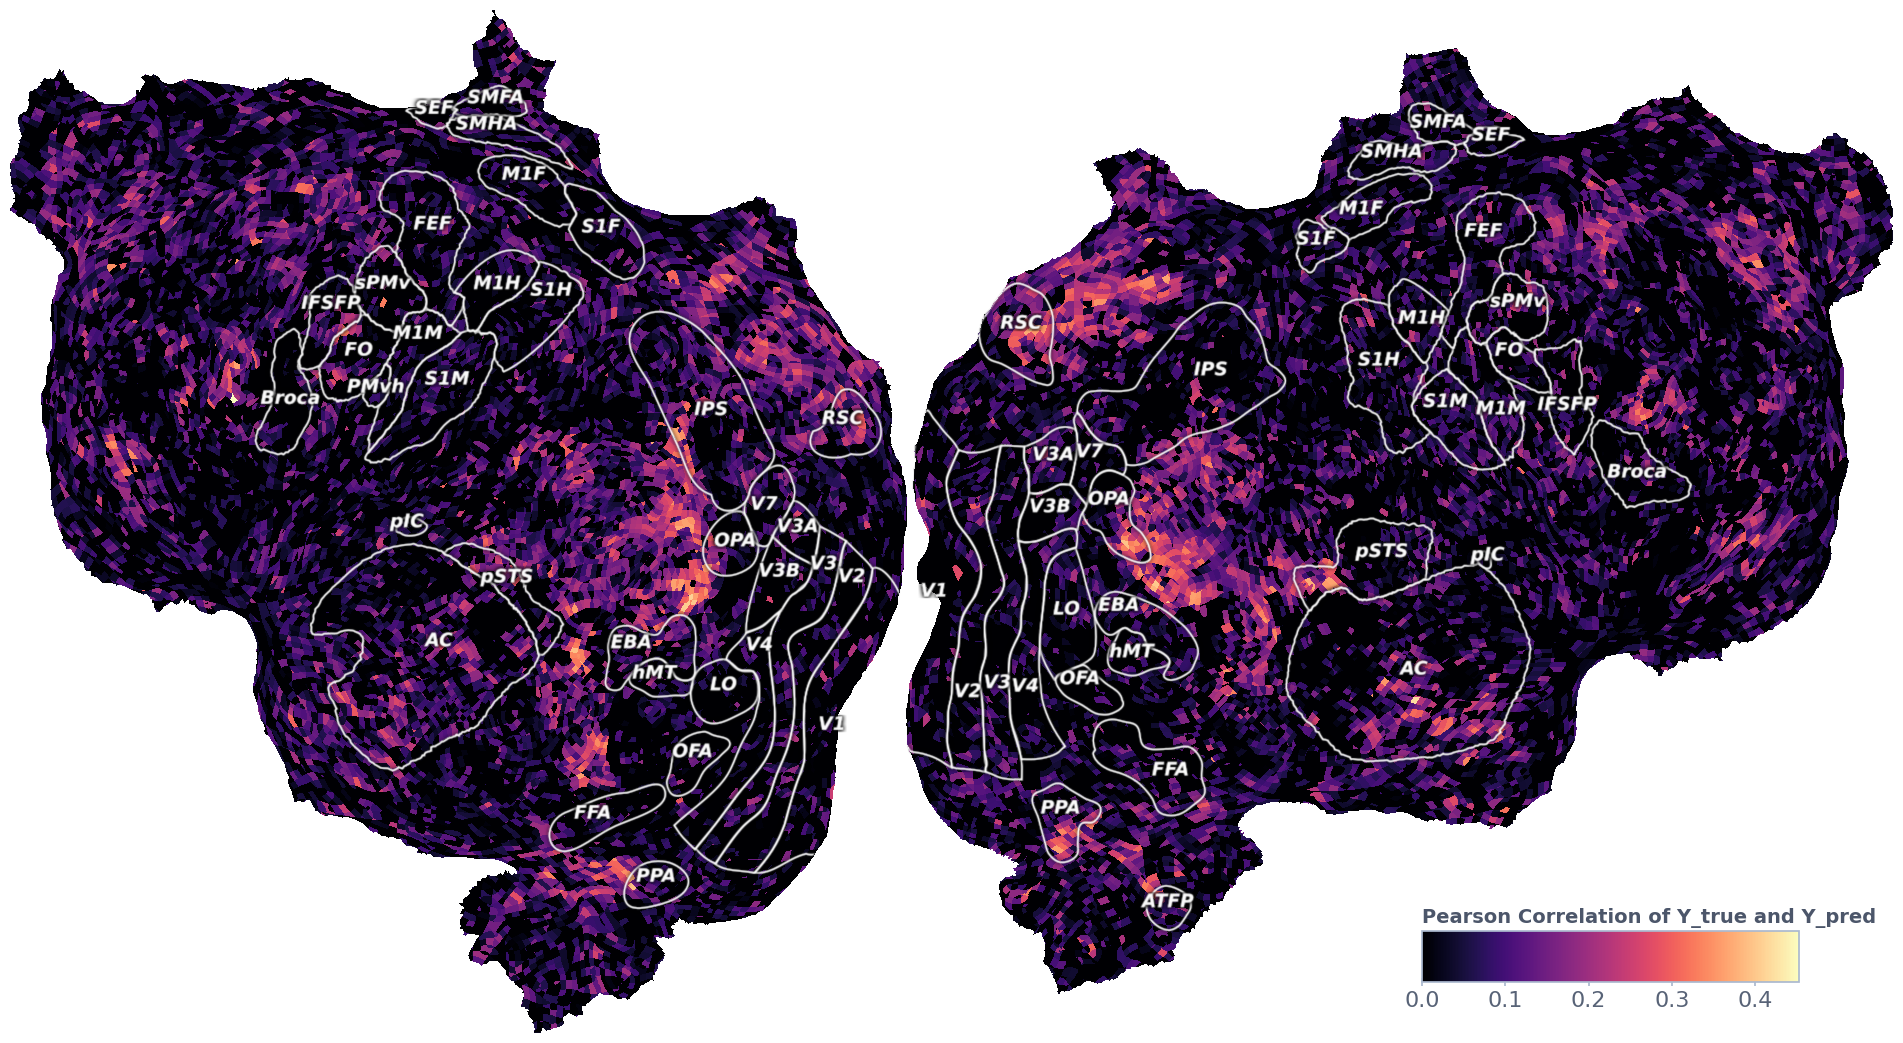

In [58]:
figsize = np.array(flatmap_mask.shape) / 100.
fig = plt.figure(figsize=figsize)
ax = fig.add_axes((0, 0, 1, 1))
ax.axis('off')

plot_flatmap_from_mapper(semantic_minus_low_level, mapper_path, ax=ax, with_curvature=False, alpha=1, vmin=0,
                         vmax=np.max(semantic_minus_low_level), colorbar_location=[0.75, 0.05, 0.2, 0.05])

plt.show()

# Residual Method

## Cross-feature Prediction

In [59]:
from himalaya.ridge import Ridge

solver_params = dict(n_targets_batch=n_targets_batch)
cross_model = Ridge(alpha=1, solver_params=solver_params)
cross_model.fit(low_level_train, semantic_train)

Ridge(solver_params={'n_targets_batch': 100})

In [60]:
cross_path = os.path.join(get_result_path(modality, subject), f"cross_{low_level_feature}_english1000_scores.csv")

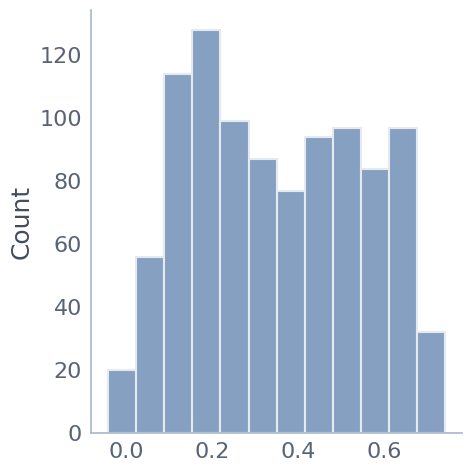

In [61]:
r2_scores = cross_model.score(low_level_val, semantic_val)
r2_scores = backend.to_numpy(r2_scores)
sns.displot(r2_scores)
r2_scores = pd.DataFrame(r2_scores, columns=['r2_cross'])
r2_scores.to_csv(cross_path, index=False)

## Create Residuals

In [62]:
semantic_pred_train = cross_model.predict(low_level_train)
semantic_pred_val = cross_model.predict(low_level_val)
print(type(semantic_pred_train))

<class 'torch.Tensor'>


In [63]:
semantic_pred_train = backend.to_numpy(semantic_pred_train)
semantic_pred_val = backend.to_numpy(semantic_pred_val)
print(semantic_pred_train.shape, semantic_pred_val.shape)

(3887, 985) (306, 985)


In [64]:
semantic_train_residual_train = semantic_train - semantic_pred_train
semantic_val_residual_val = semantic_val - semantic_pred_val

## Train on Residuals

In [65]:
residual_file = os.path.join(get_result_path(modality, subject), f"residual_english1000_{low_level_feature}_scores.csv")

In [66]:
if not os.path.exists(residual_file):
    print(f"Saving {residual_file}")
    residual_scores = run_ridge_pipeline(semantic_train_residual_train, semantic_val_residual_val, Y_train, Y_test,
                                         alphas, cv, number_of_delays, n_targets_batch, n_alphas_batch,
                                         n_targets_batch_refit)
    residual_scores.to_csv(residual_file)
else:
    print(f"Loading {residual_file}")
    residual_scores = pd.read_csv(residual_file, index_col=0)

print("max\n", residual_scores.max(), "\nmin\n", residual_scores.min(), "\nmean\n", residual_scores.mean())

Loading results/reading/subject01/residual_english1000_letters_scores.csv
max
 correlation_score_0    0.488448
correlation_score_1    0.512305
r2_score_0             0.214821
r2_score_1             0.260163
dtype: float64 
min
 correlation_score_0   -0.292987
correlation_score_1   -0.310795
r2_score_0            -0.099928
r2_score_1            -0.164032
dtype: float64 
mean
 correlation_score_0    0.026605
correlation_score_1    0.028950
r2_score_0            -0.000013
r2_score_1             0.000136
dtype: float64


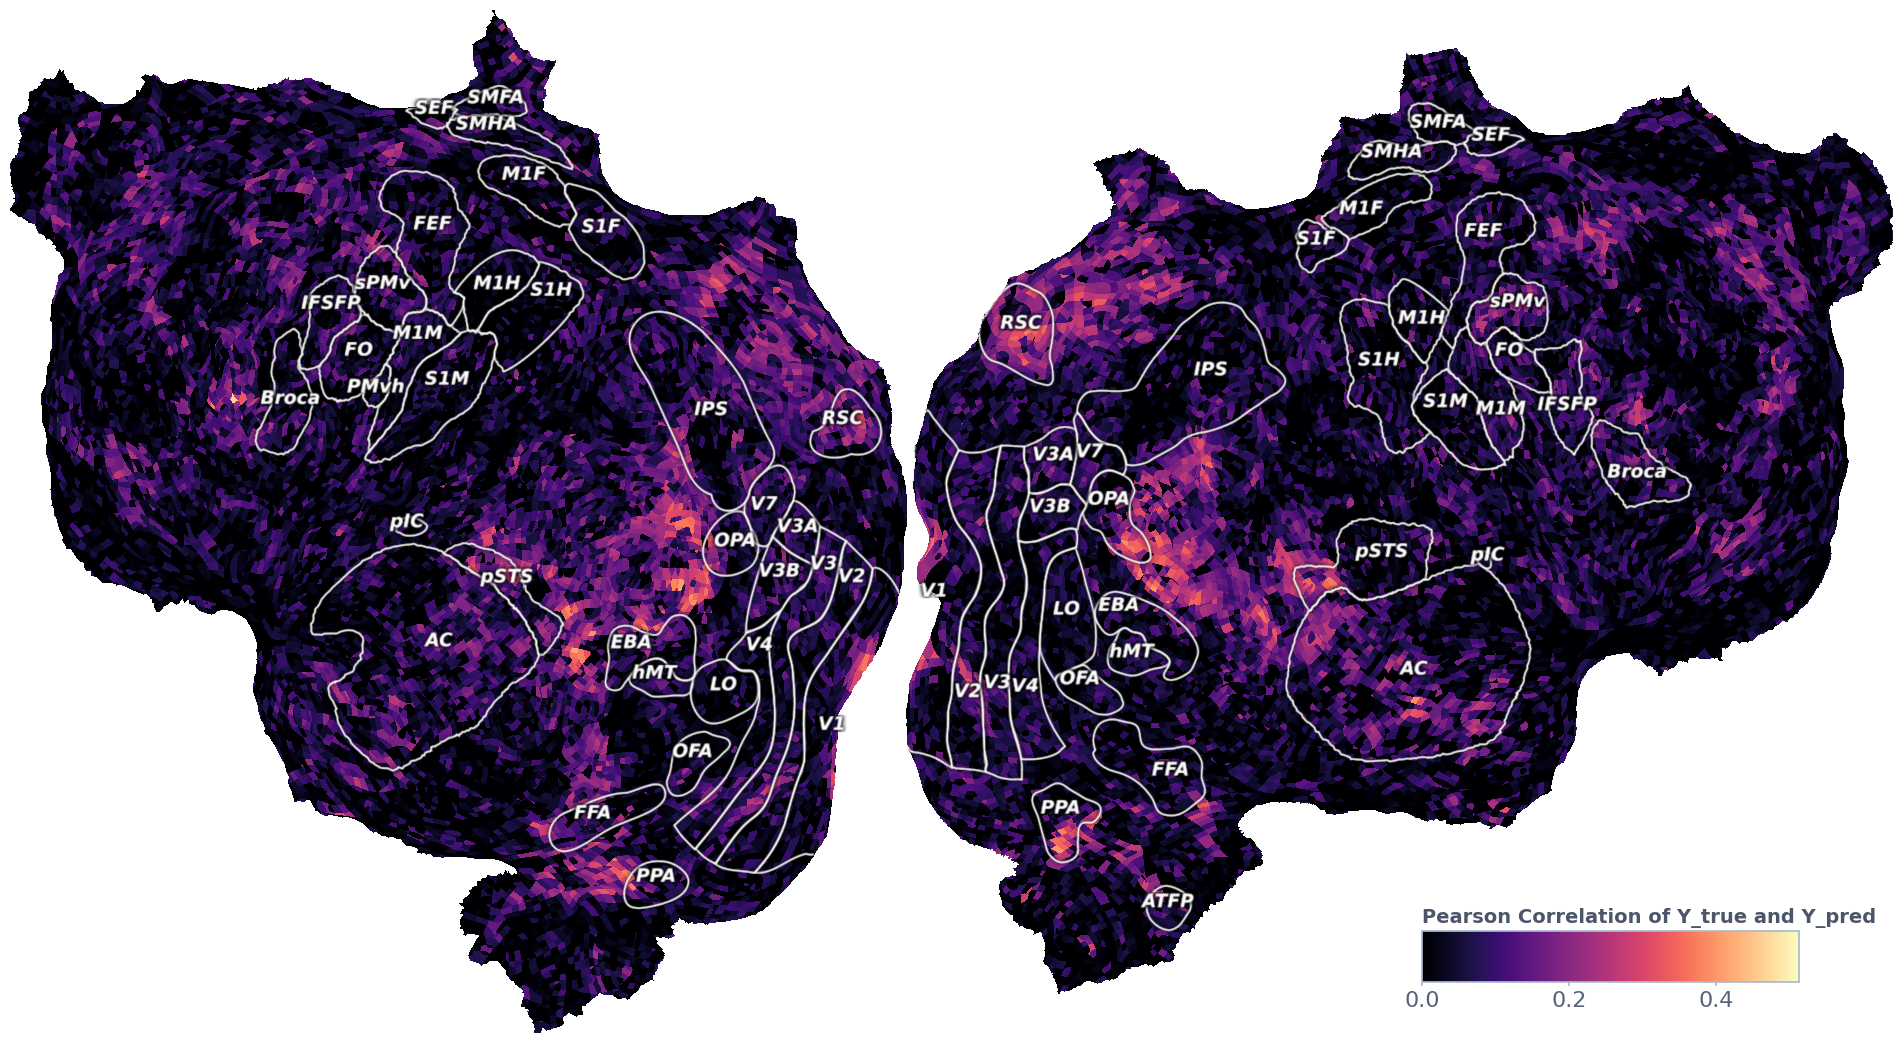

In [67]:
figsize = np.array(flatmap_mask.shape) / 100.
fig = plt.figure(figsize=figsize)
ax = fig.add_axes((0, 0, 1, 1))
ax.axis('off')

residual_correlation = residual_scores['correlation_score_1']
residual_correlation = residual_correlation.to_numpy()
residual_correlation = np.nan_to_num(residual_correlation)

plot_flatmap_from_mapper(residual_correlation, mapper_path, ax=ax, with_curvature=False, alpha=1, vmin=0,
                         vmax=np.max(residual_correlation), colorbar_location=[0.75, 0.05, 0.2, 0.05])

plt.show()